# Raport

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [88]:
data=pd.read_csv("train_egg_sales.csv",delimiter=';')

In [89]:
data.head()

,Date,Egg Sales
0,1993-01-01,91
1,1993-01-02,124
2,1993-01-03,112
3,1993-01-04,115
4,1993-01-05,107


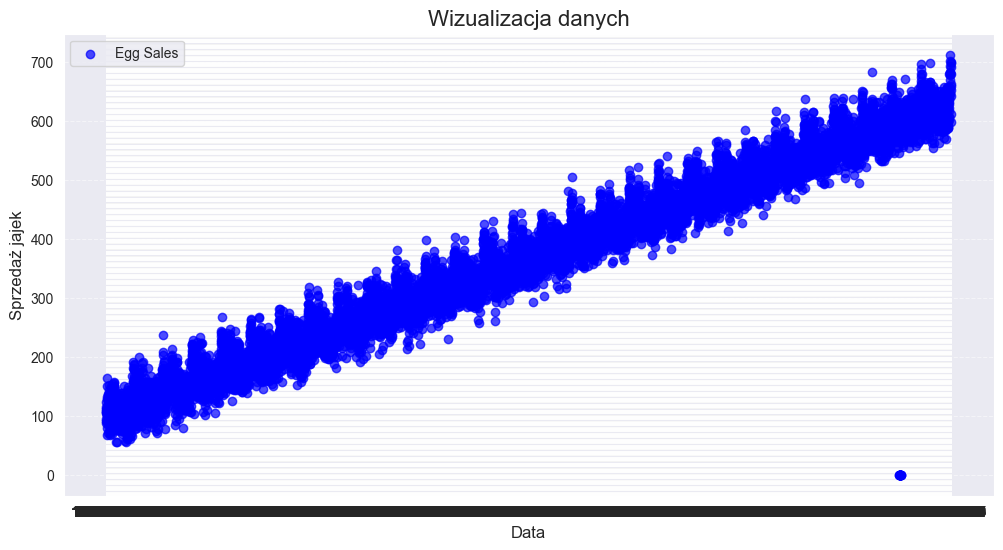

In [90]:
# Konwersja kolumny 'Date' na typ datetime, jeśli jeszcze tego nie zrobiono
#data['Date'] = pd.to_datetime(data['Date'])

# Wykres scatter
plt.figure(figsize=(12, 6))
plt.scatter(data['Date'], data['Egg Sales'], color='blue', alpha=0.7, label='Egg Sales')
plt.title('Wizualizacja danych', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Sprzedaż jajek', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## 2.1

## N/A

In [91]:
print(data.isnull().sum()) #N/A
# Liczba brakujących danych w kolumnach
missing_data = data.isnull().sum()
print(f'Brakujące dane:\n{missing_data}')

# Możemy także sprawdzić brakujące dane w kontekście wartości sprzedaży jajek
missing_sales = data[data['Egg Sales'].isnull()]
print(f'Brakujące dane w sprzedaży jajek:\n{missing_sales}')


Date         0
Egg Sales    0
dtype: int64
Brakujące dane:
Date         0
Egg Sales    0
dtype: int64
Brakujące dane w sprzedaży jajek:
Empty DataFrame
Columns: [Date, Egg Sales]
Index: []


## detekcja wartości spoza zakładanego przedziału

In [92]:
min(data['Egg Sales'])

0

In [93]:
data.nsmallest(400, 'Egg Sales')

,Date,Egg Sales
9941,2020-03-21,0
9942,2020-03-22,0
9943,2020-03-23,0
9944,2020-03-24,0
9945,2020-03-25,0
...,...,...
189,1993-07-09,118
328,1993-11-25,118
446,1994-03-23,118
496,1994-05-12,118


In [94]:
max(data['Egg Sales'])

713

In [95]:
min_value=55
max_value=713
out_of_range_data = data[(data['Egg Sales'] < min_value) | (data['Egg Sales'] > max_value)]
print(f'Liczba próbek spoza zakładanego przedziału: {len(out_of_range_data)}')

Liczba próbek spoza zakładanego przedziału: 18


## Błedy w próbkowaniu

In [96]:
# Konwersja kolumny 'Date' na typ datetime, jeśli jeszcze tego nie zrobiono
data['Date'] = pd.to_datetime(data['Date'])

# Sprawdzenie różnic między kolejnymi datami
data['Time Diff'] = data['Date'].diff()

# Jeśli różnice czasowe są zbyt duże (np. > 1 dzień), może to wskazywać na brakujące próbki
irregular_dates = data[data['Time Diff'] > pd.Timedelta(days=1)]
print(f'Nieregularne daty (z dużą różnicą czasową):\n{irregular_dates}')


Nieregularne daty (z dużą różnicą czasową):
Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


In [97]:
# Analiza wartości odstających (outliers) za pomocą IQR (Interquartile Range)
Q1 = data['Egg Sales'].quantile(0.25)
Q3 = data['Egg Sales'].quantile(0.75)
IQR = Q3 - Q1

# Zdefiniowanie przedziału wartości normalnych
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identyfikacja wartości odstających
outliers = data[(data['Egg Sales'] < lower_bound) | (data['Egg Sales'] > upper_bound)]
print(f'Wartości odstające (outliers):\n{outliers}')


Wartości odstające (outliers):
Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


## 2.2

In [98]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data

,Date,Egg Sales,Time Diff
323,1993-11-20,147,1 days
9980,2020-04-29,617,1 days
1097,1996-01-03,177,1 days
9353,2018-08-11,558,1 days
6188,2009-12-11,456,1 days
...,...,...,...
5734,2008-09-13,374,1 days
5191,2007-03-20,346,1 days
5390,2007-10-05,344,1 days
860,1995-05-11,155,1 days


## 2.3

### wykres ACF oraz PACF dla surowych danych

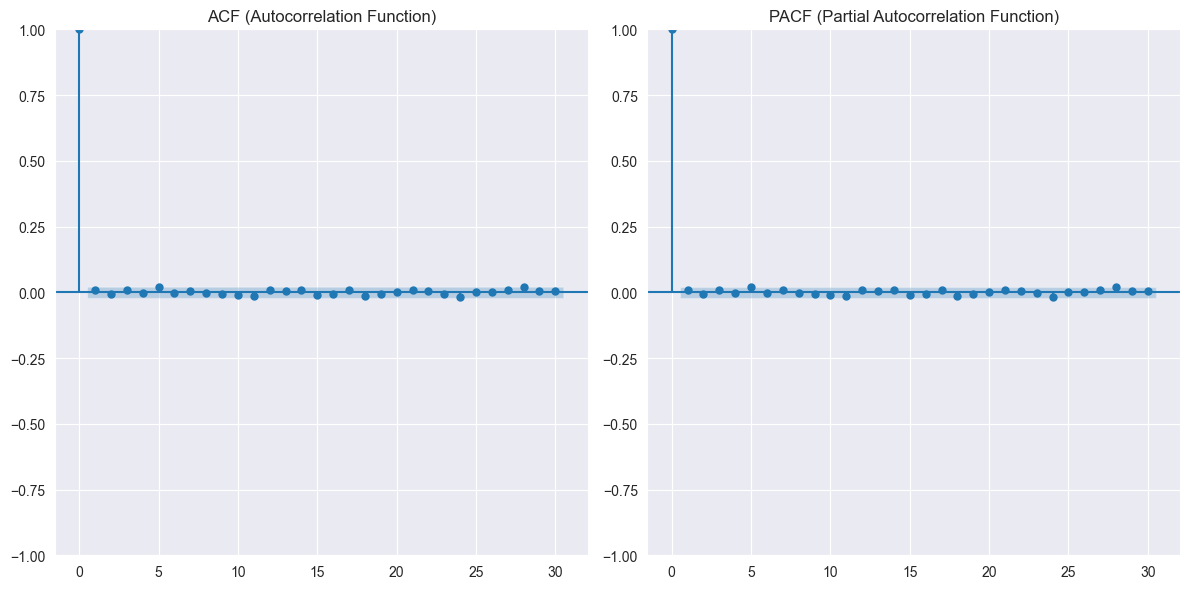

In [99]:
plt.figure(figsize=(12, 6))

# Wykres ACF (Autocorrelation Function)
plt.subplot(1, 2, 1)
plot_acf(train_data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05)
plt.title("ACF (Autocorrelation Function)")

# Wykres PACF (Partial Autocorrelation Function)
plt.subplot(1, 2, 2)
plot_pacf(train_data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05)
plt.title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
(Boxa-Coxa),
plt.show()

### identyfikacja trendów deterministycznych: metody omawiane na wykładzie oraz na laboratorium -
(zadanie 4, lista 5) / różnicowanie / różnicowanie sezonowe / transformacje stabilizujące wariancję
(Boxa-Coxa),